In [1]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator


Each image is presented as a reshaped 1D vector version of the image, next to the corresponding label in the "label" column.

Each image is labeled with a number, from 0 to 24 


Note:   
    
    (numbers 9 and 25 are skipped, corresponding to the letters "j" and "z", respectively)

In [2]:
# A simple mapping relating the label with its corresponding letter
mapping_dict = {}
value = 0
for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    if letter in ["J","Z"]:
        value += 1
        continue
    mapping_dict[letter] = value
    value += 1
inverted_dict = {v:k for k,v in mapping_dict.items()} 

In [3]:
train_df = pd.read_csv("datasets/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("datasets/sign_mnist_test/sign_mnist_test.csv")

display("train_df: ",train_df.sample(5))

y_train = train_df[['label']]
y_test = test_df[['label']]
del train_df['label']
del test_df['label']

print("Labels: ",y_train.label.sort_values().unique())

'train_df: '

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
2832,6,207,209,212,212,213,213,216,215,215,...,240,239,237,235,232,231,231,229,223,223
3745,18,135,138,139,141,143,144,146,146,149,...,92,73,58,151,173,166,168,167,168,168
25088,4,108,114,121,125,129,133,136,140,142,...,149,198,189,193,195,196,196,196,197,197
4058,23,229,231,232,232,230,230,232,232,231,...,196,219,237,204,168,191,208,227,237,243
11778,5,127,141,151,156,160,164,169,171,174,...,236,234,235,235,235,234,233,233,232,231


Labels:  [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


From the rounding 35000 of samples in total, 20% correspond to the training set, which seems appropriate

In [4]:
num_test = y_test.shape[0]
num_train = y_train.shape[0]

num_tot = num_test+num_train
print(f"Total number of samples: {num_tot}")
print(f"percentage of test samples: {100*num_test/num_tot:.2f}%")

Total number of samples: 34627
percentage of test samples: 20.71%


Categories seem balanced for both training and test sets

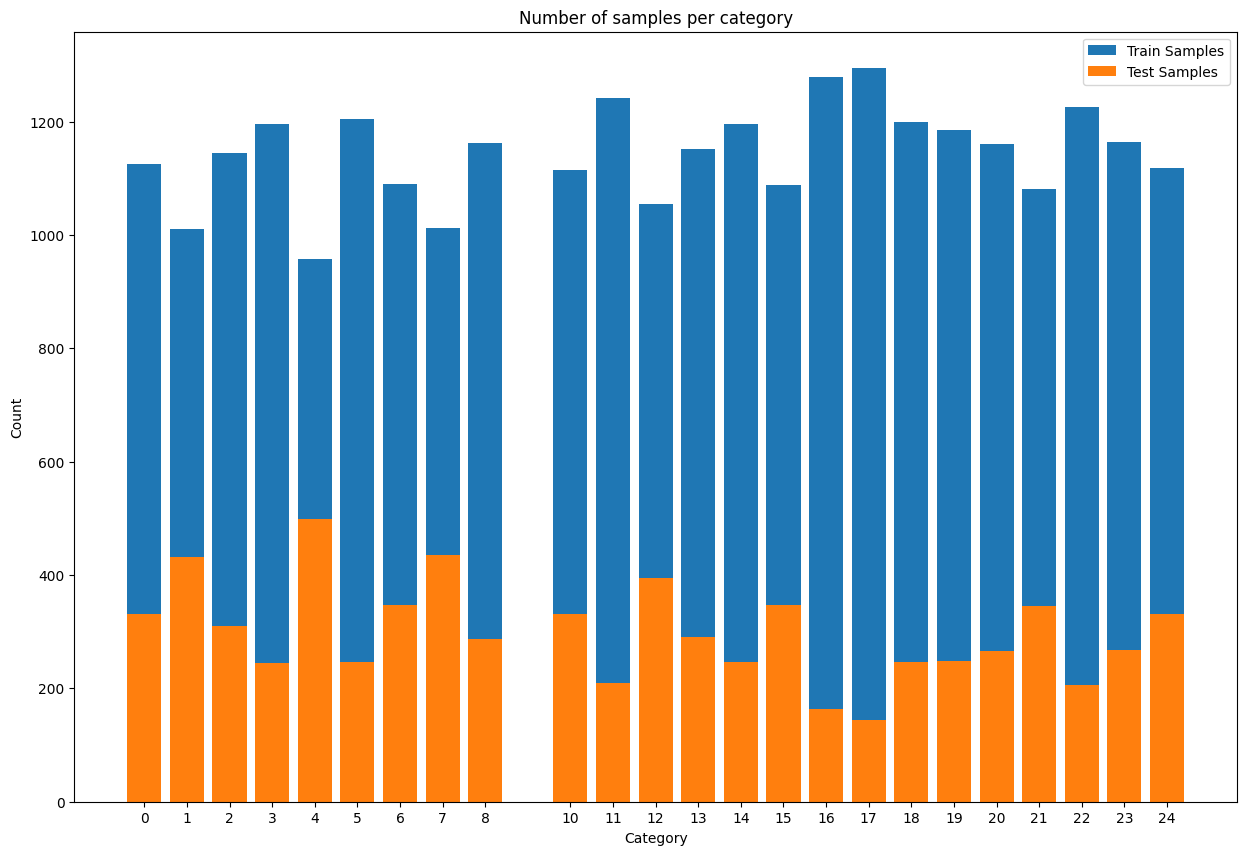

In [5]:
y_labels = y_train.label.unique()
bins = len(y_labels)

plt.figure(figsize=(15, 10))

train_label_counts = y_train.label.value_counts()
plt.bar(train_label_counts.index, train_label_counts.values, label='Train Samples')
test_label_counts = y_test.label.value_counts()
plt.bar(test_label_counts.index, test_label_counts.values, label='Test Samples')

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of samples per category')
plt.xticks(sorted(y_labels))
plt.legend()

plt.show()


In [6]:
# Preprocessing image data (each is a 28x28 pixel image)

x_train = train_df.values
x_test = test_df.values
# Normalize
x_train_norm = x_train / 255
x_test_norm = x_test / 255
# Reshape
num_pixels = int((train_df.shape[1])**(1/2))
x_train_norm = x_train_norm.reshape(-1,num_pixels,num_pixels,1)
x_test_norm = x_test_norm.reshape(-1,num_pixels,num_pixels,1)

Checking some of the images and its corresponding labels 

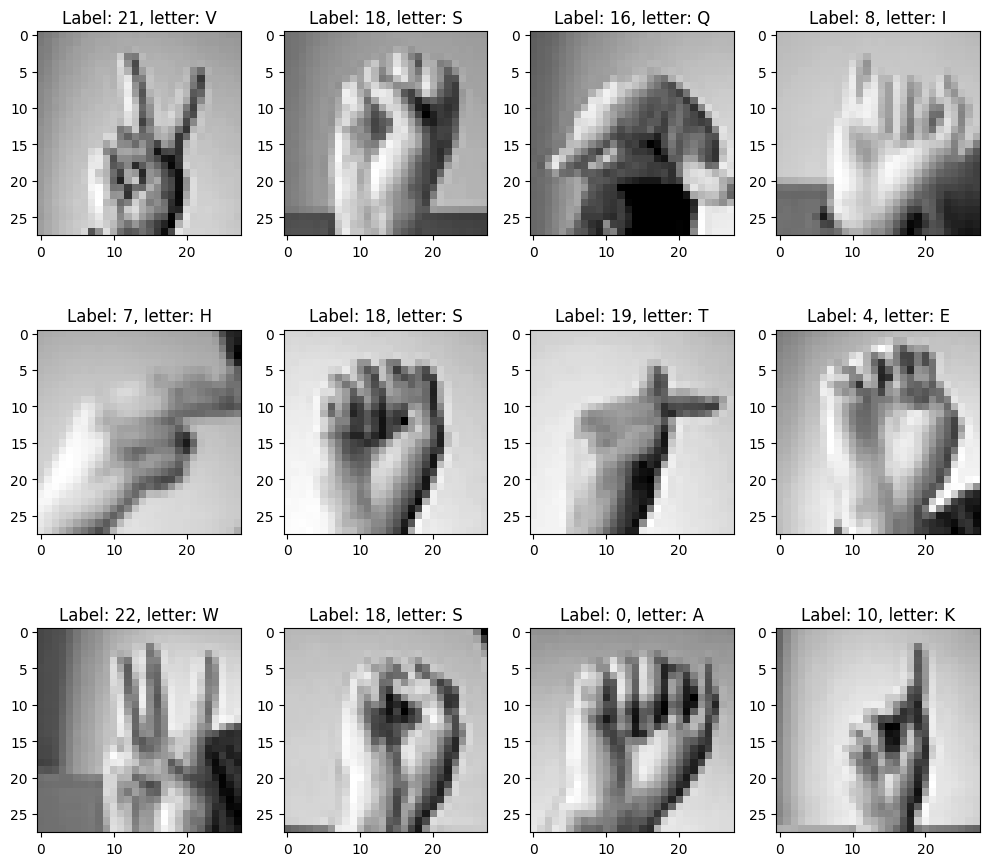

In [7]:
check_on = x_train_norm
label_on = y_train.values
n_rows = 3
n_cols = 4

f, ax = plt.subplots(n_rows,n_cols) 
f.set_size_inches(10, 10)
for i in range(n_rows):
    for j in range(n_cols):
        im_idx = random.randint(0,check_on.shape[0])
        label = label_on[im_idx][0]
        ax[i,j].imshow(check_on[im_idx].reshape(28, 28) , cmap = "gray")
        ax[i,j].set_title(f"Label: {label}, letter: {inverted_dict[label]}")
    plt.tight_layout()   

In [8]:
# OUTPUT ENCODING

oh_encoder = OneHotEncoder()

y_train_oh = oh_encoder.fit_transform(y_train)
display(y_train_oh.toarray())
y_test_oh = oh_encoder.fit_transform(y_test)
display(y_test_oh.toarray())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

Augmenting the data:


Slight rotation of 15%.

Width and height shift set to 10%

zoom range set to 10%

Brightness was set to range between 40% to 60% (brightness_range=0 means absolute darkness and brightness_range=1 maximum brightness)

The "fill_mode" parameter was chosen as "nearest" (fills with the nearest pixels), as there is not an important evident pattern to be learned in the images background.

A horizontal flip was included, since the same letters should be equally recognized when performed with the left or the right hand (inclusion means also considering people missing extremities)

Horizontal flip is set to False, since upside down sign communication is not quite a common thing :) 


In [9]:
# Data Augmentation

img_gen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        brightness_range=(0.4,0.6),
        fill_mode="nearest",
        horizontal_flip=False,
        vertical_flip=False
        )


img_gen.fit(x_train_norm)